In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from time import time
import itertools
from scipy import stats, signal

from neurodsp.filt import filter_signal
from neurodsp.timefrequency import amp_by_time
from neurodsp.sim import sim_filtered_noise, sim_bursty_oscillator
from bycycle.features import compute_features

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_style('white')
plt.style.use('Cole_2018.mplstyle')

from config import config_sim

# Simulate trial data with 3 conditions

In [2]:
# Define general simulation parameters
N_trials = 100
Fs = config_sim['fs']

tlims = (-1, 2)
T_full = tlims[1] - tlims[0]
T_burst = tlims[1]
t = np.arange(tlims[0], tlims[1], 1/Fs)

# Define simulation parameters
conditions = ['baseline', 'higher amp', 'more bursts']
colors = ['k', 'r', 'b']
osc_amps = {'baseline': 1, 'more bursts': 1, 'higher amp': 1.2}
prob_leave_bursts = {'baseline': .1, 'more bursts': .05, 'higher amp': .1}
prob_enter_bursts = {'baseline': .1, 'more bursts': .2, 'higher amp': .1}

In [3]:
# For each condition
xs = defaultdict(list)
dfs = defaultdict(list)
np.random.seed(1)
start_time = time()
for c in conditions:
    for tr in range(N_trials):
        # Simulate noise
        brown = sim_filtered_noise(T_full + 10, Fs, exponent = config_sim['exponent'],
                                   f_range=config_sim['f_range_noise'],
                                   filter_order=config_sim['filter_order_noise'])
        brown = brown[:len(t)]
        
        # Generate oscillator after time zero
        oscillator, df = sim_bursty_oscillator(T_burst, Fs, config_sim['freq_osc'], 
                                               prob_enter_burst=prob_enter_bursts[c],
                                               prob_leave_burst=prob_leave_bursts[c],
                                               rdsym = config_sim['rdsym'],
                                               cycle_features=config_sim['cycle_features'],
                                               return_cycle_df=True)

        # Normalize oscillator and noise powers
        if df['is_cycle'].sum() > 0:
            # Determine when oscillation is present
            osc_present = np.zeros(len(oscillator), dtype=bool)
            for i, row in df.iterrows():
                if row['is_cycle']:
                    osc_present[row['start_sample']: row['start_sample'] + row['period']] = True

            # Normalize noise by relative variance of 2 signals
            ratio_osc_var = 2
            oscillator_var = np.var(oscillator[osc_present])
            brown_var = np.var(brown)
            brown = np.sqrt(brown**2 * oscillator_var /
                            (brown_var * ratio_osc_var)) * np.sign(brown)
                
        # Add oscillator after time zero
        x = np.copy(brown)
        x[-len(oscillator):] += oscillator*osc_amps[c]
        xs[c].append(x)
        dfs[c].append(df)
    print('Completed condition {:s}, # seconds = {:.0f}'.format(c, time() - start_time))

/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of

Completed condition baseline, # seconds = 63
Completed condition higher amp, # seconds = 118
Completed condition more bursts, # seconds = 184


# A. Visualize single trials for each condition

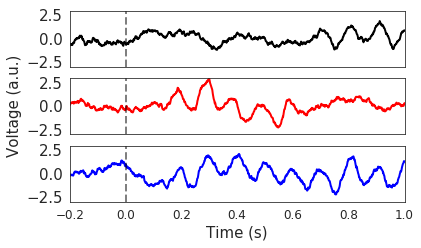

In [4]:
ymax = 3

trial_plot = {'baseline': 6, 'higher amp': 2, 'more bursts': 2}
plt.figure(figsize=(6,6))
for i, (k, color) in enumerate(zip(conditions, colors)):
    plt.subplot(5, 1, i+1)
    plt.plot(t, xs[k][trial_plot[k]], color=color)
    plt.plot([0,0], [-ymax, ymax], 'k--', alpha=.5)
    plt.xlim((-.2, 1))
    plt.ylim((-ymax,ymax))
    
    if i == len(conditions) - 1:
        plt.xticks(size=12)
    elif i == 1:
        plt.ylabel('Voltage (a.u.)', size=15)
        plt.xticks([])
    else:
        plt.xticks([])
plt.xlabel('Time (s)', size=15)

plt.savefig('figs/4A_condition_timeseries', bbox_inches='tight')

### example trial amplitude profiles

In [5]:
# Compute average instantaneous amplitude
amps = defaultdict(list)
mean_amp_ts = defaultdict()
for c in conditions:
    for tr in range(N_trials):
        amps[c].append(amp_by_time(xs[c][tr], Fs, config_sim['f_range'],
                                   filter_kwargs={'compute_transition_band': False},
                                   remove_edge_artifacts=False))
    mean_amp_ts[c] = np.mean(np.array(amps[c]), axis=0)

Text(0, 0.5, 'Amplitude (a.u.)')

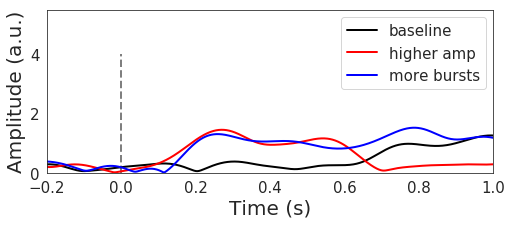

In [6]:
plt.figure(figsize=(8,3))
plt.plot([0,0], [0, 4], 'k--', alpha=.5)
for i, (k, color) in enumerate(zip(conditions, colors)):
    plt.plot(t, amps[k][trial_plot[k]], color=color, label=k)
    plt.xlim((-.2, 1))
    plt.ylim((0, 5.5))
plt.legend(fontsize=15)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (a.u.)')

# B. Average event-related amplitudes for simulated conditions

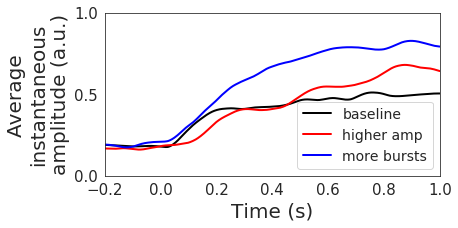

In [7]:
plt.figure(figsize=(6, 3))
for i, c in enumerate(conditions):
    plt.plot(t, mean_amp_ts[c], label=c, color=colors[i])

plt.xlim((-.2, 1))
plt.ylim((0, 1))
plt.yticks(np.arange(0,1.1,.5))
plt.legend(loc='best', fontsize=14)
plt.xlabel('Time (s)')
plt.ylabel('Average\ninstantaneous\namplitude (a.u.)')

plt.savefig('figs/4B_inst_amp_ts', bbox_inches='tight')

# Compute cycle by cycle features

In [8]:
# Define event-related bins
bin_edges = np.arange(-.5, 1.1, .1)
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2

xs_filt = defaultdict(list)
binned_amps = defaultdict()
binned_bursts = defaultdict()
dfs_shape = defaultdict(list)
for c in conditions:
    for tr in range(N_trials):
        # Apply lowpass filter
        x_filt = filter_signal(xs[c][tr], Fs, 'lowpass', config_sim['lowpass_fc'],
                                n_seconds=config_sim['lowpass_n_seconds'],
                                compute_transition_band=False,
                                remove_edge_artifacts=False)
        xs_filt[c].append(x_filt)
        
        df_shape = compute_features(x_filt, Fs, config_sim['f_range'], center_extrema='P',
                                    burst_detection_kwargs=config_sim['osc_detect_kwargs'])
        df_shape['trial'] = tr
        
        # divide by 2 because amp is peak-to-trough whereas instamp is zero-to-peak
        df_shape['volt_amp'] = df_shape['volt_amp'] / 2
        dfs_shape[c].append(df_shape)
        
    # Aggregate all trials
    df_shape_cond = pd.concat(dfs_shape[c]).reset_index(drop=True)[['sample_peak', 'volt_amp', 'is_burst']]
    # Compute time from sample
    df_shape_cond['t'] = t[df_shape_cond['sample_peak'].values]
    # Bin time
    df_shape_cond['t_bin'] = pd.cut(df_shape_cond['t'], bin_edges)
    
    # Compute bursting and amp in each time bin
    df_burst_by_t = df_shape_cond.groupby('t_bin')['is_burst'].mean()
    df_amp_by_t = df_shape_cond[df_shape_cond['is_burst']].groupby('t_bin')['volt_amp'].mean()
    binned_amps[c] = df_amp_by_t.values
    binned_bursts[c] = df_burst_by_t.values

/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars

# C. Average event-related cycle-by-cycle amplitudes

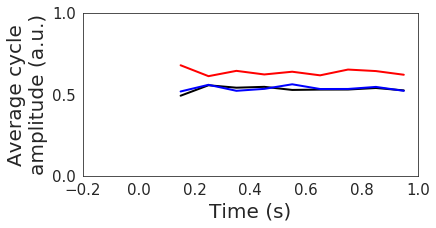

In [17]:
plt.figure(figsize=(6,3))
for i, c in enumerate(conditions):
    plt.plot(bin_centers[6:], binned_amps[c][6:] / 2, label=c, color=colors[i])

plt.xlim((-.2, 1))
plt.ylim((0, 1))
plt.yticks(np.arange(0,1.1,.5))
plt.xlabel('Time (s)')
plt.ylabel('Average cycle\namplitude (a.u.)')

plt.savefig('figs/4C_cycle_amp_ts', bbox_inches='tight')

# D. Average event-related bursting

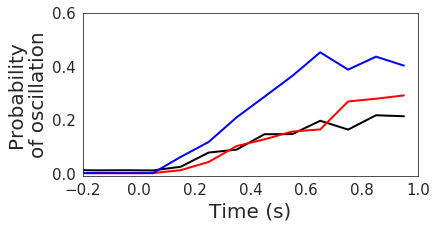

In [10]:
plt.figure(figsize=(6,3))
for i, c in enumerate(conditions):
    plt.plot(bin_centers, binned_bursts[c], label=c, color=colors[i])

plt.xlim((-.2, 1))
plt.ylim((-.01,.6))
plt.xlabel('Time (s)')
plt.ylabel('Probability\nof oscillation')

plt.savefig('figs/4D_cycle_burst_ts', bbox_inches='tight')

# Significance tests: instantaneous amplitude

In [11]:
# Compute mean instantaneous amplitude 500ms to 1000ms for each condition
tlim = (.5, 1)
tidxs = np.logical_and(t>=tlim[0], t<tlim[1])
inst_amp_trial_means = {}
for c in conditions:
    inst_amp_trial_means[c] = np.mean(np.array([x[tidxs] for x in amps[c]]), axis=1)
    
# Test for differences between mean isntantaneous amplitudes
c1 = 'baseline'
for c2 in conditions[1:]:
    U, p = stats.mannwhitneyu(inst_amp_trial_means[c1], inst_amp_trial_means[c2])
    print('{:14s},  {:14s}: U={:3.0f}, p={:.6f}, p={:.0E}, mu1={:.2f}, mu2={:.2f}'.format(c1, c2, U, p, p,
                                                                                np.mean(inst_amp_trial_means[c1]),
                                                                                np.mean(inst_amp_trial_means[c2])))

baseline      ,  higher amp    : U=4480, p=0.102160, p=1E-01, mu1=0.49, mu2=0.60
baseline      ,  more bursts   : U=2781, p=0.000000, p=3E-08, mu1=0.49, mu2=0.79


# Significance tests: cycle amplitude

In [12]:
# Compute mean cycle amplitude 500ms to 1000ms for each condition
tlim = (.5, 1)
tidxs = np.logical_and(t>=tlim[0], t<tlim[1])
cycle_amp_trial_means = {}
for c in conditions:
    # Get dataframe of interest
    df_temp = pd.concat(dfs_shape[c])
    df_temp = df_temp[df_temp['is_burst']]
    df_temp['t'] = t[df_temp['sample_peak'].values]
    df_temp = df_temp[(df_temp['t']>=tlim[0]) & (df_temp['t']<tlim[1])]
    cycle_amp_trial_means[c] = df_temp.groupby('trial')['volt_amp'].mean()
    
    
# Test for differences between mean isntantaneous amplitudes
c1 = 'baseline'
for c2 in conditions[1:]:
    U, p = stats.mannwhitneyu(cycle_amp_trial_means[c1], cycle_amp_trial_means[c2])
    print('{:14s},  {:14s}: U={:3.0f}, p={:.6f}, p={:.0E}, mu1={:.2f}, mu2={:.2f}'.format(c1, c2, U, p, p,
                                                                                np.mean(cycle_amp_trial_means[c1]),
                                                                                np.mean(cycle_amp_trial_means[c2])))

baseline      ,  higher amp    : U=182, p=0.000004, p=4E-06, mu1=1.07, mu2=1.26
baseline      ,  more bursts   : U=819, p=0.374645, p=4E-01, mu1=1.07, mu2=1.07


# E. Distribution comparison (amp, baseline): instantaneous amp

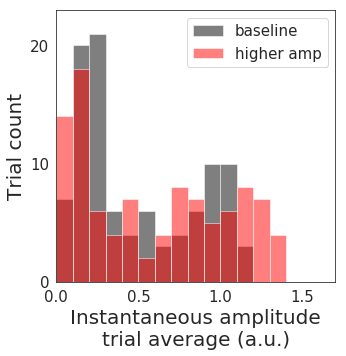

In [13]:
# Histogram of mean instantaneous amplitudes to see trial differentiation
plt.figure(figsize=(5,5))
for i, c in enumerate(['baseline', 'higher amp']):
    plt.hist(inst_amp_trial_means[c], bins=np.arange(0, 4, .1), label=c, alpha=.5, color=colors[i])

plt.xlim((0, 1.7))
plt.ylim((0, 23))
plt.yticks(np.arange(0, 22, 10))
plt.legend(loc='best', fontsize=15)
plt.ylabel('Trial count')
plt.xlabel('Instantaneous amplitude\ntrial average (a.u.)')

plt.savefig('figs/4E_inst_amp_dist', bbox_inches='tight')

# F. Distribution comparison (amp, baseline): cycle amp

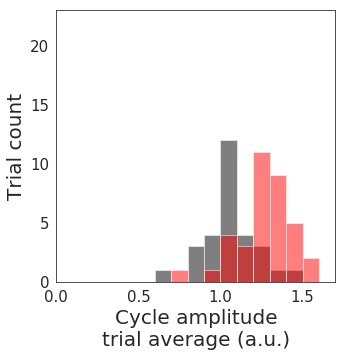

In [14]:
# Histogram of mean cycle amplitudes to see trial differentiation
plt.figure(figsize=(5,5))
for i, c in enumerate(['baseline', 'higher amp']):
    plt.hist(cycle_amp_trial_means[c], bins=np.arange(0, 4, .1), label=c, alpha=.5, color=colors[i])

plt.xlim((0, 1.7))
plt.ylim((0, 23))
plt.ylabel('Trial count')
plt.xlabel('Cycle amplitude\ntrial average (a.u.)')
plt.yticks(np.arange(0, 22, 5))

plt.savefig('figs/4F_cycle_amp_dist', bbox_inches='tight')

# G. Distribution comparison (more bursting, baseline): instantaneous amp

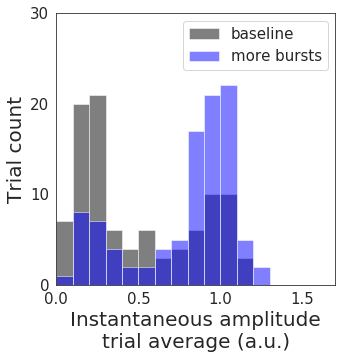

In [15]:
# Histogram of mean instantaneous amplitudes to see trial differentiation
plt.figure(figsize=(5,5))
for c, color in zip(['baseline', 'more bursts'], ['k', 'b']):
    plt.hist(inst_amp_trial_means[c], bins=np.arange(0, 4, .1), label=c, alpha=.5, color=color)

plt.xlim((0, 1.7))
plt.ylim((0, 30))
plt.legend(loc='best', fontsize=15)
plt.ylabel('Trial count')
plt.xlabel('Instantaneous amplitude\ntrial average (a.u.)')
plt.yticks(np.arange(0, 31, 10))

plt.savefig('figs/4G_inst_amp_dist', bbox_inches='tight')

# H. Distribution comparison (more bursting, baseline): cycle amp

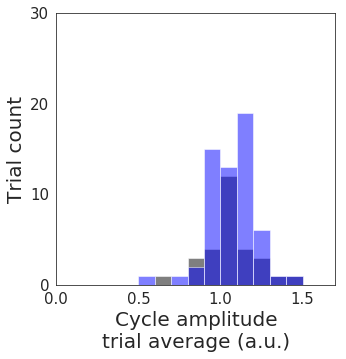

In [16]:
# Histogram of mean cycle amplitudes to see trial differentiation
plt.figure(figsize=(5,5))
for c, color in zip(['baseline', 'more bursts'], ['k', 'b']):
    plt.hist(cycle_amp_trial_means[c], bins=np.arange(0, 4, .1), label=c, alpha=.5, color=color)

plt.xlim((0, 1.7))
plt.ylim((0, 30))
plt.ylabel('Trial count')
plt.xlabel('Cycle amplitude\ntrial average (a.u.)')
plt.yticks(np.arange(0, 31, 10))

plt.savefig('figs/4H_cycle_amp_dist', bbox_inches='tight')